# Chapter 1: Introduction

This notebook produces the plot for the figure 1.1.

In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

np.random.seed(99999)

FIGPATH = Path(os.getcwd()).parent / "plots"

## Simple DGP

In [ ]:
@dataclass
class DGP():
    """
    simple DGP for illustration purpose

    Args:
        n (int): Number of samples.
        p (int): Number of variables.
    """
    n: int = 1_000
    p: int = 15
    rho: float = .5
    r2: float = .6

    def __post_init__(self):
        self.sigma = np.array([[self.rho ** np.abs(k - j) for k in range(self.p)] for j in range(self.p)])

        beta = np.array([(-1) ** (j+1) / (j+1) ** 2 for j in range(self.p)])
        beta *= np.sqrt(self.r2 / (1 - self.r2) / (beta.T @ self.sigma @ beta))
        self.beta = beta

    def sigmoid(self, x):
        return 1 / (1 + np.exp(- x))
    
    def generate(self, n=None):
        if n is None:
            n = self.n
        X = multivariate_normal(mean=np.zeros(self.p), cov=self.sigma).rvs(size=n)
        eps = np.random.random(size=(n,))
        y = 1 * (eps > self.sigmoid(X @ self.beta) )
        return X, y
    

## Generate train data and fit the model

In [ ]:
dgp = DGP()
X_train, y_train = dgp.generate(n=10_000)

logit = LogisticRegression(C=1e6)
logit.fit(X_train, y_train)


## Evaluate the ROC curve on a test sample

In [ ]:
X_test, y_test = dgp.generate(n=1000)
y_hat = logit.predict_proba(X_test)

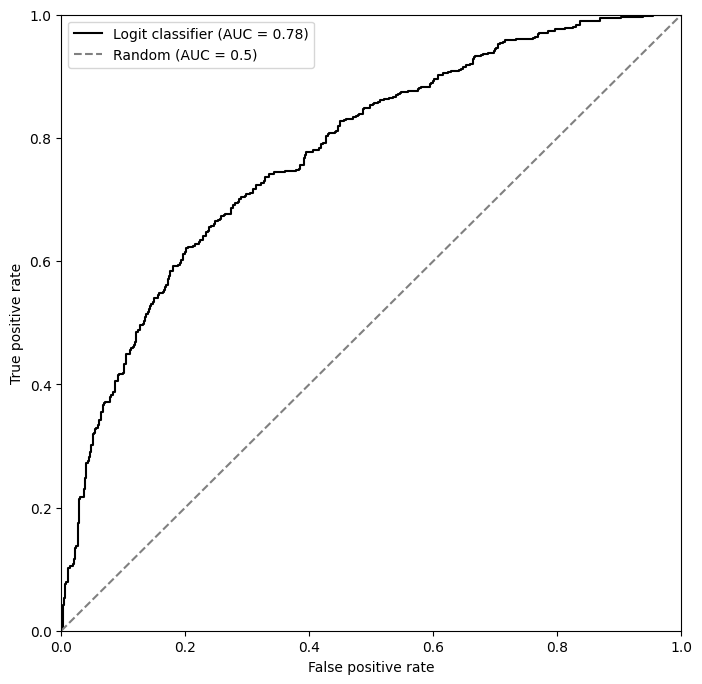

In [54]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_hat[:,1])
auc_ = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(fpr, tpr, color='black', label=f"Logit classifier (AUC = {auc_:.2f})")
ax.axline([0, 0], [1, 1], linestyle="--", color="grey", label=f"Random (AUC = 0.5)")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

plt.savefig(
    FIGPATH / 'Fig_1_1.jpg',
    dpi=300,
    orientation='portrait',
    bbox_inches='tight'
    )